In [1]:
import os, sys, urllib, gzip, glob
import cPickle as pickle
sys.setrecursionlimit(10000)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.misc import imread
from IPython.display import Image as IPImage
from PIL import Image

In [3]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

Using gpu device 0: Tesla K40c (CNMeM is disabled)


In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print 'Using cuda_convnet (faster)'
except TypeError: #ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print 'Using lasagne.layers (slower)'

Using cuda_convnet (faster)


In [5]:
# Load data
data_path = '/home/local/yahog/neuralnets/ldrhdr/data/'
#hdr = glob.glob(os.path.join(data_path, '*.pkl'))
ldr = glob.glob(os.path.join(data_path, '*.jpg'))

data_ldr = np.zeros((len(ldr), 1, 256, 256))
data_hdr = np.zeros((len(ldr), 1, 256, 256))

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

for idx, image in enumerate(ldr):
    data[idx, 1, :, :] = rgb2gray(imread(image))
    with open(image[:-7] + "_hdr.pkl", 'rb') as fhdl:
        data_hdr[idx, 1, :, :] = rgb2gray(pickle.load(fhdl))
    

In [6]:
# reshape from (50000, 784) to 4D tensor (50000, 1, 28, 28)
#X = np.reshape(X, (-1, 1, 28, 28))
print 'data_ldr type and shape:', data_ldr.dtype, data_ldr.shape
print 'data_ldr.min():', data_ldr.min()
print 'data_ldr.max():', data_ldr.max()

X type and shape: float32 (50000, 1, 28, 28)
X.min(): 0.0
X.max(): 0.996094


In [7]:
# we need our target to be 1 dimensional
data_hdr = data_hdr.reshape((X.shape[0], -1))
print 'X_out:', data_hdr.dtype, data_hdr.shape

X_out: float32 (50000, 784)


In [8]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 800}),
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 5, 5))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayerSlow, {'num_filters': 1, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [9]:
ae = NeuralNet(
    layers=layers,
    max_epochs=20,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

In [10]:
ae.fit(data_ldr, data_hdr)

# Neural Network with 224177 learnable parameters

## Layer information

  #  name          size
---  ------------  --------
  0  input0        1x28x28
  1  conv2dcc1     16x26x26
  2  conv2dcc2     16x24x24
  3  maxpool2dcc3  16x12x12
  4  conv2dcc4     32x10x10
  5  maxpool2dcc5  32x5x5
  6  reshape6      800
  7  dense7        128
  8  encode        16
  9  dense9        128
 10  dense10       800
 11  reshape11     32x5x5
 12  upscale2d12   32x10x10
 13  conv2dcc13    16x12x12
 14  upscale2d14   16x24x24
 15  conv2d15      16x26x26
 16  conv2d16      1x28x28
 17  reshape17     784

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -------
      1       0.06966       0.05405      1.28875  140.59s
      2       0.04523       0.03716      1.21718  175.31s
      3       0.03323       0.02991      1.11093  154.54s
      4       0.02850       0.02687      1.06094  142.74s
      5       0.02618       0.02503      1.04612  192.67s
     

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f98dbbc67d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f98dbbc6750>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}...d': 'full', 'num_filters': 1}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7f98dbbca320>,
     objective_loss_function=<function squared_error at 0x7f98e0092410>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f98dbbcf2d8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInf

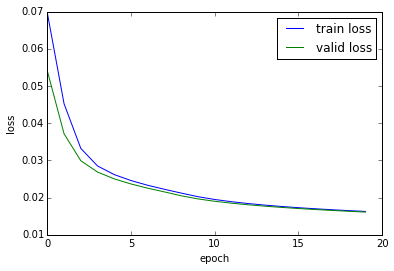

In [11]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

In [12]:
# ae.save_params_to('mnist/conv_ae.np')
pickle.dump(ae, open('mnist/conv_ae.pkl','w'))
# ae = pickle.load(open('mnist/conv_ae.pkl','r'))
# ae.layers

In [13]:
X_pred = ae.predict(X).reshape(-1, 28, 28)
X_pred = np.rint(256. * X_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print X_pred.shape , X.shape

(50000, 28, 28) (50000, 1, 28, 28)


In [14]:
!mkdir -p data
!mkdir -p montage

2


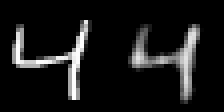

In [15]:
###  show random inputs / outputs side by side

def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(index):
    print index
    original_image = Image.fromarray(get_picture_array(255 * X[index]))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred[index]))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")
    return IPImage('data/test.png')

compare_images(2)
# compare_images(np.random.randint(50000))

In [16]:
## we find the encode layer from our ae, and use it to define an encoding function

def get_layer_by_name(net, name):
    for i, layer in enumerate(net.get_all_layers()):
        if layer.name == name:
            return layer, i
    return None, None
encode_layer, encode_layer_index = get_layer_by_name(ae, 'encode')

def encode_input(encode_layer, X):
    return get_output(encode_layer, inputs=X).eval()

X_encoded = encode_input(encode_layer, X)

In [17]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

(1, 784)


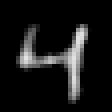

In [26]:
#def get_output_from_nn(last_layer, X):
#    indices = np.arange(128, X.shape[0], 128)
#    sys.stdout.flush()
#
#    # not splitting into batches can cause a memory error
#    X_batches = np.split(X, indices)
#    out = []
#    for count, X_batch in enumerate(X_batches):
#        out.append(get_output(last_layer, X_batch).eval())
#        sys.stdout.flush()
#    return np.vstack(out)

def get_output_from_nn(last_layer, X):
    return get_output(last_layer,X).eval()

def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

X_decoded = 256 * decode_encoded_input(X_encoded[2])

X_decoded = np.rint(X_decoded).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print X_decoded.shape

pic_array = get_picture_array(X_decoded)
image = Image.fromarray(pic_array)
image.save('data/test.png', format="PNG")  
IPImage('data/test.png')

In [23]:
enc_std = X_encoded.std(axis=0)
enc_mean = X_encoded.mean(axis=0)
enc_min = X_encoded.min(axis=0)
enc_max = X_encoded.max(axis=0)
m = X_encoded.shape[1]

In [24]:
n = 256
generated = np.random.normal(0, 1, (n, m)) * enc_std + enc_mean
generated = generated.astype(np.float32).clip(enc_min, enc_max)
X_decoded = decode_encoded_input(generated) * 256.
X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
!mkdir -p montage
for i in range(n):
    pic_array = get_picture_array(X_decoded[i], rescale=1)
    image = Image.fromarray(pic_array)
    image.save('montage/{0:03d}.png'.format(i), format='png')

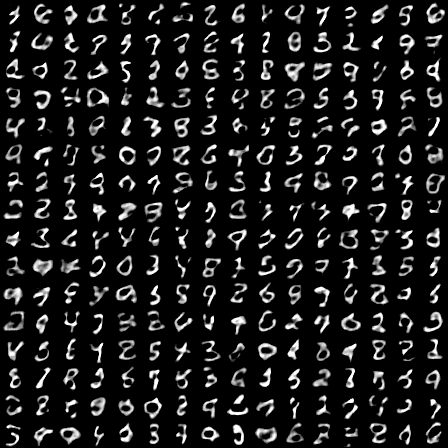

In [25]:
!montage -mode concatenate -tile 16x montage/*.png montage.png
IPImage('montage.png')